In [1]:
import pandas as pd
import random
import numpy as np

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rules
from sklearn import svm as svm

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

from sklearn.decomposition import PCA 


# Misc
import warnings
warnings.filterwarnings("ignore")
random.seed(1137)

In [2]:
louisville = pd.read_csv('data/processed/louisville_dv.csv')

# fill in missing ages with median value
louisville['age_days'].fillna(louisville['age_days'].median(), inplace=True)

In [4]:
y = louisville[['euthanasia']]
X = louisville.drop(columns=['euthanasia', 'city'])

train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25, random_state=1137)

In [5]:
# generate ten fold cross validation, preprocess pipeline (min-max scaler), and define the search space

fold_generator = KFold(n_splits=10, shuffle=True, random_state=1137)

pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])


search_space = [

        # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[10,20],
    'model__n_estimators':[500],
    'model__random_state':[1137]},
]

In [6]:
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

In [7]:
search.fit(train_X,train_y.euthanasia)

GridSearchCV(cv=KFold(n_splits=10, random_state=1137, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [RandomForestClassifier(max_depth=20,
                                                           n_estimators=500,
                                                           random_state=1137)],
                          'model__max_depth': [10, 20],
                          'model__n_estimators': [500],
                          'model__random_state': [1137]}],
             scoring='roc_auc')

In [8]:
search.best_score_

0.867090671281422

In [9]:
# store the best model
rf_mod = search.best_estimator_

In [10]:
m.roc_auc_score(train_y,rf_mod.predict_proba(train_X)[:,1])

0.9169608932079425

In [11]:
m.accuracy_score(train_y,rf_mod.predict(train_X))

0.8392889866226865

In [35]:
# Mean Test Score Comparison Table Creation

# store scores and errors for graphing confidence intervals
scores = search.cv_results_.get('mean_test_score')
errors = search.cv_results_.get('std_test_score')

search.cv_results_.get('params')
models = [
    'RandomForest, maxdepth:10, trees:500',
    'RandomForest, maxdepth:20, trees:500',
]

#create table dataframe
d = {'model':models, 'mean_test_score':scores, 'mean_st_err':errors}
table = pd.DataFrame(data=d)

#create intervals
table['low'] = table['mean_test_score'] - 2*table['mean_st_err']
table['high'] = table['mean_test_score'] + 2*table['mean_st_err']
table['max'] = (table['mean_test_score'] == table['mean_test_score'].max())

table

,model,mean_test_score,mean_st_err,low,high,max
0,"RandomForest, maxdepth:10, trees:500",0.841058,0.003368,0.834322,0.847794,False
1,"RandomForest, maxdepth:20, trees:500",0.867091,0.003348,0.860396,0.873786,True


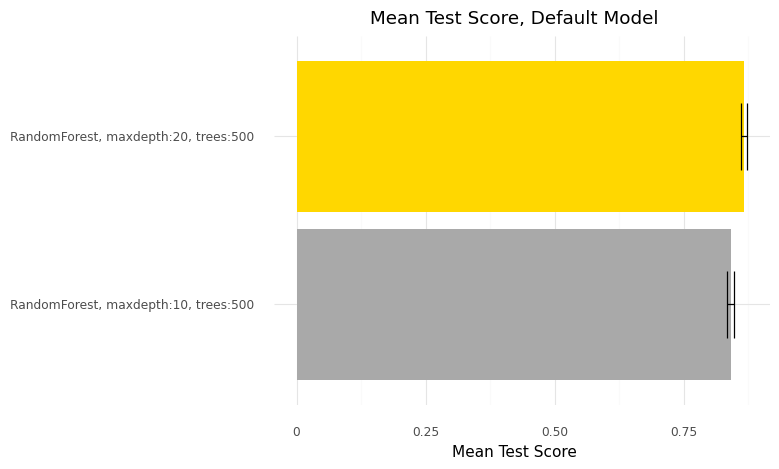

<ggplot: (8783146093093)>

In [36]:
# plot the mean test score averages, denoting the max value in a different color
(
ggplot(table, aes(x='model', y='mean_test_score',
                  fill='max')) + 
    geom_col() + 
    geom_errorbar(aes(ymin="low",ymax="high"),width=.4) + 
    scale_fill_manual(values=('darkgray','gold'), guide=None) + 
    coord_flip() + 
    labs(x='', y='Mean Test Score', title='Mean Test Score, Default Model') + 
    theme_minimal()
)

In [14]:
preds = rf_mod.predict_proba(train_X)[:,1]

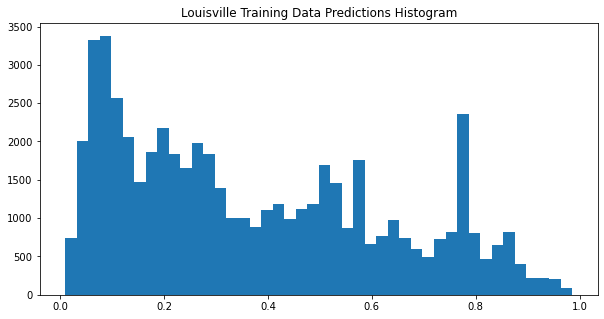

In [38]:
# observe the distribution of probabilities predicted

plt.hist(preds, bins='auto')
plt.rcParams["figure.figsize"] = (10, 5)
plt.title("Louisville Training Data Predictions Histogram")
plt.show()


              precision    recall  f1-score   support

           0       0.85      0.91      0.88     34480
           1       0.82      0.72      0.77     20090

    accuracy                           0.84     54570
   macro avg       0.83      0.81      0.82     54570
weighted avg       0.84      0.84      0.84     54570



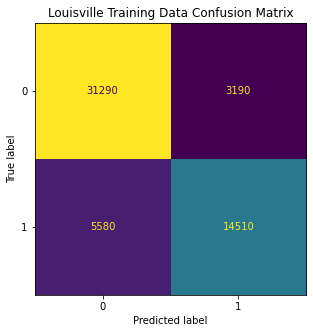

In [49]:
# copy predicted values to tweak cut-off for evaluating volatility of precision and recall

preds_bin = preds.copy()

preds_bin = np.where(preds_bin >= .5, 1, preds_bin)
preds_bin = np.where(preds_bin < .5, 0, preds_bin)

print(m.classification_report(train_y, preds_bin))

m.ConfusionMatrixDisplay.from_predictions(train_y, preds_bin, colorbar=False)
plt.rcParams["figure.figsize"] = (5, 5)
plt.title('Louisville Training Data Confusion Matrix')
plt.legend('',frameon=False)
plt.show()

## Louisville Variable Importance

In [17]:
## Feature Importance

vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=3)

# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat



# store
#vi_dat.to_csv("vi_dat_20_800.csv", index=False)


,variable,vi,std,low,high
0,age_days,0.092872,0.000681,0.091509,0.094234
1,intake_repro_altered,0.047560,0.000127,0.047305,0.047814
2,intake_type_owner surrender,0.034439,0.000067,0.034304,0.034574
3,intake_type_stray,0.015527,0.000416,0.014696,0.016359
4,intake_repro_intact,0.009822,0.000429,0.008964,0.010681
...,...,...,...,...,...
259,intake_subtype_transfer,0.000000,0.000000,0.000000,0.000000
260,english foxhound,-0.000006,0.000023,-0.000052,0.000040
261,schipperke,-0.000006,0.000009,-0.000023,0.000011
262,tibetan terrier,-0.000006,0.000009,-0.000023,0.000011


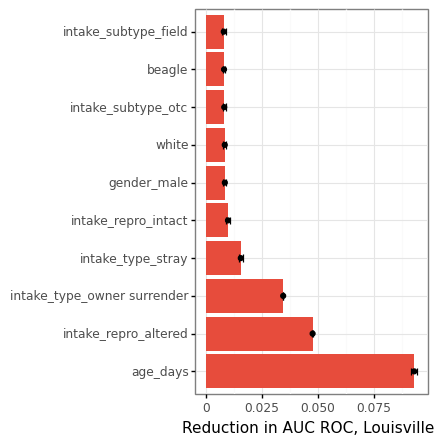

<ggplot: (8783195705188)>

In [46]:
# Plot the most important variables
(
    ggplot(vi_dat[0:10],
          aes(x="variable",y="vi")) +
    geom_col(fill="#e74c3c") +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat[0:10].variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC, Louisville",x="") + 
    theme(figure_size=(3,5))
         )

## Louisville Test Data

In [19]:
preds_t = rf_mod.predict_proba(test_X)[:,1]

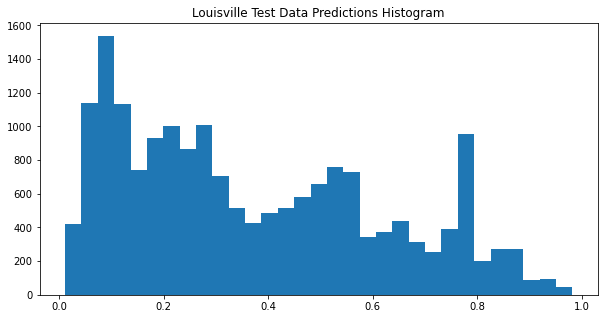

In [39]:
plt.hist(preds_t, bins='auto')
plt.rcParams["figure.figsize"] = (10, 5)
plt.title("Louisville Test Data Predictions Histogram")
plt.show()


              precision    recall  f1-score   support

           0       0.88      0.80      0.84     11596
           1       0.70      0.80      0.75      6594

    accuracy                           0.80     18190
   macro avg       0.79      0.80      0.79     18190
weighted avg       0.81      0.80      0.80     18190



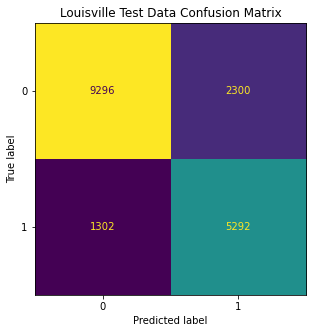

In [50]:
preds_bin_t = preds_t.copy()

preds_bin_t = np.where(preds_bin_t >= .4, 1, preds_bin_t)
preds_bin_t = np.where(preds_bin_t < .4, 0, preds_bin_t)

print(m.classification_report(test_y, preds_bin_t))

m.ConfusionMatrixDisplay.from_predictions(test_y, preds_bin_t, colorbar=False)
plt.rcParams["figure.figsize"] = (5, 5)
plt.title('Louisville Test Data Confusion Matrix')
plt.show()

## Louisville Dataset - PCA
Repeat the above process, using data that has been additional pre-processed via PCA to see if feature reduction provides significantly better results.

In [22]:
# Split the data into a training and test dataset partitioning 75% of the data into the training data, and
# holding out 25% of the data as a test set. Set a seed to replicate your split.


yp = louisville[['euthanasia']]
Xp = louisville.drop(columns=['euthanasia', 'city'])

pca = PCA(n_components=20)
pca = pca.fit(Xp)
Xp = pca.transform(Xp)

train_Xp, test_Xp, train_yp, test_yp = train_test_split(Xp,yp,test_size = .25,random_state=1137)

## Model Fit & Evaluation - PCA

In [23]:
search_pca = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

In [24]:
search_pca.fit(train_Xp,train_yp.euthanasia)

GridSearchCV(cv=KFold(n_splits=10, random_state=1137, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [RandomForestClassifier(max_depth=10,
                                                           n_estimators=500,
                                                           random_state=1137)],
                          'model__max_depth': [10, 20],
                          'model__n_estimators': [500],
                          'model__random_state': [1137]}],
             scoring='roc_auc')

In [25]:
search_pca.best_params_

{'model': RandomForestClassifier(max_depth=10, n_estimators=500, random_state=1137),
 'model__max_depth': 10,
 'model__n_estimators': 500,
 'model__random_state': 1137}

In [26]:
rf_mod_pca = search_pca.best_estimator_

In [27]:
m.roc_auc_score(train_yp,rf_mod_pca.predict_proba(train_Xp)[:,1])

0.8960300349413717

In [33]:
# Mean Test Score Comparison Table Creation

scores_pca = search_pca.cv_results_.get('mean_test_score')
errors_pca = search_pca.cv_results_.get('std_test_score')

search_pca.cv_results_.get('params')
models_pca = [
    'RandomForest, maxdepth:10, trees:1000',
    'RandomForest, maxdepth:20, trees:500'
]

dp = {'model':models_pca, 'mean_test_score':scores_pca, 'mean_st_err':errors_pca}
table_pca = pd.DataFrame(data=dp)

table_pca['low'] = table_pca['mean_test_score'] - 2*table_pca['mean_st_err']
table_pca['high'] = table_pca['mean_test_score'] + 2*table_pca['mean_st_err']
table_pca['max'] = (table_pca['mean_test_score'] == table_pca['mean_test_score'].max())

#table_pca.to_csv('model_test_score_table_PCA.csv', index=False)
table_pca

,model,mean_test_score,mean_st_err,low,high,max
0,"RandomForest, maxdepth:10, trees:1000",0.863769,0.003537,0.856695,0.870842,True
1,"RandomForest, maxdepth:20, trees:500",0.854573,0.004220,0.846133,0.863013,False


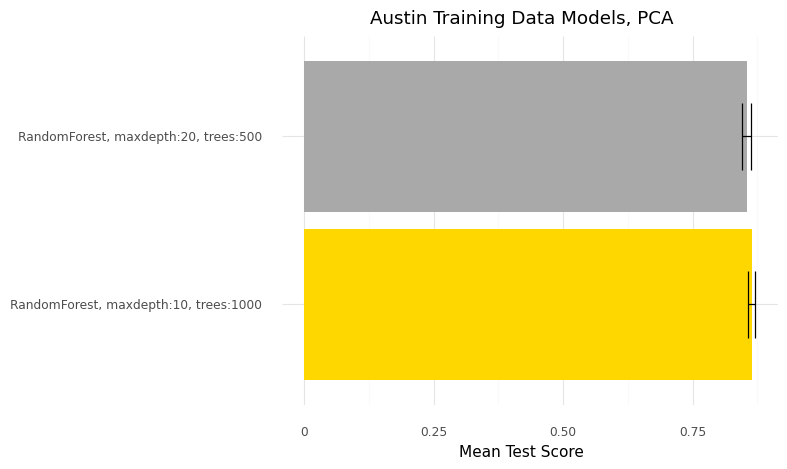

<ggplot: (8783195718632)>

In [34]:
(
ggplot(table_pca, aes(x='model', y='mean_test_score',
                  fill='max')) + 
    geom_col() + 
    geom_errorbar(aes(ymin="low",ymax="high"),width=.4) + 
    scale_fill_manual(values=('darkgray','gold'), guide=None) + 
    coord_flip() + 
    labs(x='', y='Mean Test Score', title="Austin Training Data Models, PCA") + 
    theme_minimal()
)

## Plot & Evaluate Predictions - PCA

In [30]:
preds_pca = rf_mod_pca.predict_proba(train_Xp)[:,1]


              precision    recall  f1-score   support

           0       0.88      0.82      0.85     34480
           1       0.73      0.81      0.77     20090

    accuracy                           0.82     54570
   macro avg       0.80      0.82      0.81     54570
weighted avg       0.82      0.82      0.82     54570



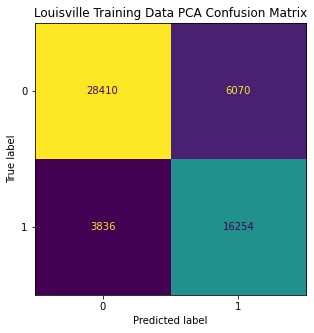

In [31]:
preds_pca_bin = preds_pca.copy()

preds_pca_bin = np.where(preds_pca_bin >= .4, 1, preds_pca_bin)
preds_pca_bin = np.where(preds_pca_bin < .4, 0, preds_pca_bin)

print(m.classification_report(train_yp, preds_pca_bin))

m.ConfusionMatrixDisplay.from_predictions(train_yp, preds_pca_bin, colorbar=False)
plt.rcParams["figure.figsize"] = (5, 5)
plt.title('Louisville Training Data PCA Confusion Matrix')
plt.show()